<a href="https://colab.research.google.com/github/IcaroTheCreator/Predicoes-de-lesoes-em-esportes/blob/Icaro/Modelos%20base/nfl_injury_analysis_versao_icaro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://github.com/Lexie88rus/NFL-1st-and-Future/raw/master/assets/image.jpg)

[Photo by Dave Adamson on Unsplash](https://unsplash.com/photos/-nATH0CrkMU)

# NFL Injury Analysis

It is incredible how we can apply data science to different areas of our life. Even in sports, data science can help to make the game safer for the athletes.

The main goal of this analysis is to find out factors, which lead to injury. In particular, find out if the effects that synthetic turf versus natural turf can have on player movements and the factors that may contribute to lower extremity injuries.

In [ ]:
import numpy as np
import pandas as pd #processamento de dados, para abrir o dataset (arquivo .csv)
import itertools

from google.colab import drive #para conectar o google drive ao notebook e trazer os datasets para cá
drive.mount('/content/drive') #diretório onde o drive vai ser instaurado

#from google.colab import files #função import para justamente fazer o upload dos arquivos do drive
#uploaded = files.upload()

import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/Datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# image utils
import PIL
from PIL import Image

# import plotting
import matplotlib.pyplot as plt #biblioteca mais comum para plotar as imagens
import seaborn as sns
import scipy.stats as ss

# import machine learning
from sklearn.model_selection import StratifiedKFold #função da biblioteca sklearn para dividir os sets
from imblearn.over_sampling import RandomOverSampler, SMOTE #funções para over sampling (aumentar quantidade de ex da classe minoritária (lesão))
import xgboost as xgb #um dos modelos de ML
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score #funções que irão avaliar os modelos por meio de scores

Mounted at /content/drive
/content/drive/My Drive/Datasets/InjuryRecord.csv
/content/drive/My Drive/Datasets/PlayList.csv
/content/drive/My Drive/Datasets/PlayerTrackData.csv
/content/drive/My Drive/Datasets/Features001.csv
/content/drive/My Drive/Datasets/adult/adult.test
/content/drive/My Drive/Datasets/adult/Index
/content/drive/My Drive/Datasets/adult/adult.names
/content/drive/My Drive/Datasets/adult/adult.data
/content/drive/My Drive/Datasets/adult/old.adult.names


## Load Data

Load the data as pandas dataframes:

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #instanciando o google drive novamente só pra ter certeza que vai dar certo

play_df = pd.read_csv('/content/drive/My Drive/Datasets/PlayList.csv')
#player_df = pd.read_csv('/content/drive/My Drive/Datasets/PlayerTrackData.csv')
#este último dataset foi comentado pois ele pesa 3.7 GB e estoura a memória RAM gratuita do Colab
injury_df = pd.read_csv('/content/drive/My Drive/Datasets/InjuryRecord.csv')

import numpy as np
from sklearn.datasets import load_iris
import pandas as pd

# Loading irirs dataset
df = pd.DataFrame(injury_df)
rows = len(df.axes[0])
col = len(df.axes[1])

print("Numero de colunas:", col)
print("Numero de linhas:", rows)

# Get the list of all column names from headers
nomes_colunas = list(df.columns.values)
print("Nomes das colunas:", nomes_colunas)


display(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Numero de colunas: 9
Numero de linhas: 105
Nomes das colunas: ['PlayerKey', 'GameID', 'PlayKey', 'BodyPart', 'Surface', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']


,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1
...,...,...,...,...,...,...,...,...,...
100,44423,44423-13,NaN,Knee,Synthetic,1,0,0,0
101,31933,31933-20,NaN,Knee,Synthetic,1,0,0,0
102,47285,47285-4,NaN,Knee,Natural,1,1,0,0
103,37068,37068-19,NaN,Knee,Natural,1,1,0,0


## Data Exploration

First of all, I would like to perform the initial cleaning and make visualizations to get familiar with the data and generate the ideas for further analysis.

### Play Dataset Exploration

`1` General information:

In [ ]:
unique_players = play_df.PlayerKey.nunique()
unique_games = play_df.GameID.nunique()
unique_plays = play_df.PlayKey.nunique()

#as funções acima são para justamente contar quantos elementos únicos existem, pois alguns se repetem
#e abaixo é a impressão destes resultados

print('There are {} players in the dataset.'.format(unique_players))
print('There are {} games in the dataset.'.format(unique_games))
print('There are {} plays in the dataset.'.format(unique_plays))


There are 250 players in the dataset.
There are 5712 games in the dataset.
There are 267005 plays in the dataset.


`2` Game exploration:

In [ ]:
# Criar um DataFrame com informações a nível de jogo.
game_df = play_df[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])

In [ ]:
# https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
def add_value_labels(ax, spacing=5, decimals = 0):
    """Adicionar rótulos ao final de cada barra em um gráfico de barras.
    Variáveis:
        ax (matplotlib.axes.Axes): o objeto em maplotlib que contém os eixos da plotagem para anotar.
        spacing (int): a distância entre os rótulos e as barras do gráfico.
    """

    # Para cada barra: Coloque um rótulo.
    for rect in ax.patches:
        # Obtenha a posição X e Y do rótulo a partir do retângulo.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Número de pontos entre a barra e o rótulo. Altere conforme desejar.
        space = spacing
        # Alinhamento vertical para valores positivos.
        va = 'bottom'

        # Se o valor da barra for negativo: Coloque o abaixo da barra.
        if y_value < 0:
            # Inverter o espaço para colocar o rótulo abaixo.
            space *= -1
            # Alinhamento vertical do rótulo no topo
            va = 'top'

        # Usar o valor de Y como rótulo e formatar o número para uma casa decimal
        format_str = "{:." + str(decimals) + "f}"
        label = format_str.format(y_value)

        # Criar anotação
        ax.annotate(
            label,                      # Usar 'label' como rótulo
            (x_value, y_value),         # Colocar o rótulo ao final da barra
            xytext=(0, space),          # Deslocar o rótulo verticalmente com 'space'
            textcoords="offset points", # Interpreta `xytext` como compensação nos pontos
            ha='center',                # Centraliza o rótulo horizontalmente
            va=va)                      # Alinha verticalmente o rótulo de diferentes maneiras para valores positivos e negativos



def visualize_game_features(game_df, rotation = 90, add_labels = False, figsize=(10,10)):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(4, 3, hspace=0.2, wspace=0.2)
    stadium_ax = fig.add_subplot(grid[0, :2])
    fieldtype_ax = fig.add_subplot(grid[0, 2])
    weather_ax = fig.add_subplot(grid[1, 0:])
    temperature_ax = fig.add_subplot(grid[2, 0:])
    temperature_box_ax = fig.add_subplot(grid[3, 0:])

    stadium_ax.bar(game_df.StadiumType.value_counts().keys(), game_df.StadiumType.value_counts().values, color='#00c2c7')
    stadium_ax.set_title('StadiumType')
    stadium_ax.set_xticklabels(game_df.StadiumType.value_counts().keys(), rotation=rotation)

    if add_labels:
        add_value_labels(stadium_ax, spacing=5)

    fieldtype_ax.bar(game_df.FieldType.value_counts().keys(), game_df.FieldType.value_counts().values, color=['#00c2c7', '#ff9e15'])
    fieldtype_ax.set_title('FieldType')
    fieldtype_ax.set_xticklabels(game_df.FieldType.value_counts().keys(), rotation=0)

    if add_labels:
        add_value_labels(fieldtype_ax, spacing=5)

    weather_ax.bar(game_df.Weather.value_counts().keys(), game_df.Weather.value_counts().values, color='#00c2c7')
    weather_ax.set_title('Weather')
    weather_ax.set_xticklabels(game_df.Weather.value_counts().keys(), rotation=rotation)

    if add_labels:
        add_value_labels(weather_ax, spacing=5)

    temperature_ax.hist(game_df.Temperature.astype(int).values, bins=30, range=(0,90))
    temperature_ax.set_xlim(0,110)
    temperature_ax.set_xticks(range(0,110,10))
    temperature_ax.set_xticklabels(range(0,110,10))
    temperature_ax.set_title('Temperature')

    temperature_box_ax.boxplot(game_df.Temperature.astype(int).values, vert=False)
    temperature_box_ax.set_xlim(0,110)
    temperature_box_ax.set_xticks(range(0,110,10))
    temperature_box_ax.set_xticklabels(range(0,110,10))
    temperature_box_ax.set_yticklabels(['Temperature'])

    plt.suptitle('Game-Level Exploration', fontsize=16)
    plt.show()

In [ ]:
def clean_weather(row):
    cloudy = ['Cloudy 50% change of rain', 'Hazy', 'Cloudy.', 'Overcast', 'Mostly Cloudy',
          'Cloudy, fog started developing in 2nd quarter', 'Partly Cloudy',
          'Mostly cloudy', 'Rain Chance 40%',' Partly cloudy', 'Party Cloudy',
          'Rain likely, temps in low 40s', 'Partly Clouidy', 'Cloudy, 50% change of rain','Mostly Coudy', '10% Chance of Rain',
          'Cloudy, chance of rain', '30% Chance of Rain', 'Cloudy, light snow accumulating 1-3"',
          'cloudy', 'Coudy', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy fog started developing in 2nd quarter', 'Cloudy light snow accumulating 1-3"',
         'Cloudywith periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy 50% change of rain', 'Cloudy and cold',
       'Cloudy and Cool', 'Partly cloudy']

    clear = ['Clear, Windy',' Clear to Cloudy', 'Clear, highs to upper 80s',
             'Clear and clear','Partly sunny',
             'Clear, Windy', 'Clear skies', 'Sunny', 'Partly Sunny', 'Mostly Sunny', 'Clear Skies',
             'Sunny Skies', 'Partly clear', 'Fair', 'Sunny, highs to upper 80s', 'Sun & clouds', 'Mostly sunny','Sunny, Windy',
             'Mostly Sunny Skies', 'Clear and Sunny', 'Clear and sunny','Clear to Partly Cloudy', 'Clear Skies',
            'Clear and cold', 'Clear and warm', 'Clear and Cool', 'Sunny and cold', 'Sunny and warm', 'Sunny and clear']

    rainy = ['Rainy', 'Scattered Showers', 'Showers', 'Cloudy Rain', 'Light Rain', 'Rain shower', 'Rain likely, temps in low 40s.', 'Cloudy, Rain']

    snow = ['Heavy lake effect snow']

    indoor = ['Controlled Climate', 'Indoors', 'N/A Indoor', 'N/A (Indoors)']

    if row.Weather in cloudy:
        return 'Cloudy'

    if row.Weather in indoor:
        return 'Indoor'

    if row.Weather in clear:
        return 'Clear'

    if row.Weather in rainy:
        return 'Rain'

    if row.Weather in snow:
        return 'Snow'

    if row.Weather in ['Cloudy.', 'Heat Index 95', 'Cold']:
        return np.nan

    return row.Weather

def clean_stadiumtype(row):
    if row.StadiumType in ['Bowl', 'Heinz Field', 'Cloudy']:
        return np.nan
    else:
        return row.StadiumType

def clean_play_df(play_df):
    play_df_cleaned = play_df.copy()

    # clean StadiumType
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Retr. Roof-Closed|Outdoor Retr Roof-Open|Retr. Roof - Closed|Retr. Roof-Open|Retr. Roof - Open|Retr. Roof Closed', 'Retractable Roof')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace('Open', 'Outdoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned.apply(lambda row: clean_stadiumtype(row), axis=1)

    # clean Weather
    play_df_cleaned['Weather'] = play_df_cleaned.apply(lambda row: clean_weather(row), axis=1)

    return play_df_cleaned

<ipython-input-6-a7d17a9c9ee9>:56: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
<ipython-input-6-a7d17a9c9ee9>:57: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
<ipython-input-6-a7d17a9c9ee9>:58: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
<ipython-input-6-a7d17a9c9ee9>:59: FutureWarning: The default value of regex will change from True to False in a future version.
  play_df_cleaned['StadiumType'] = play_df_cle

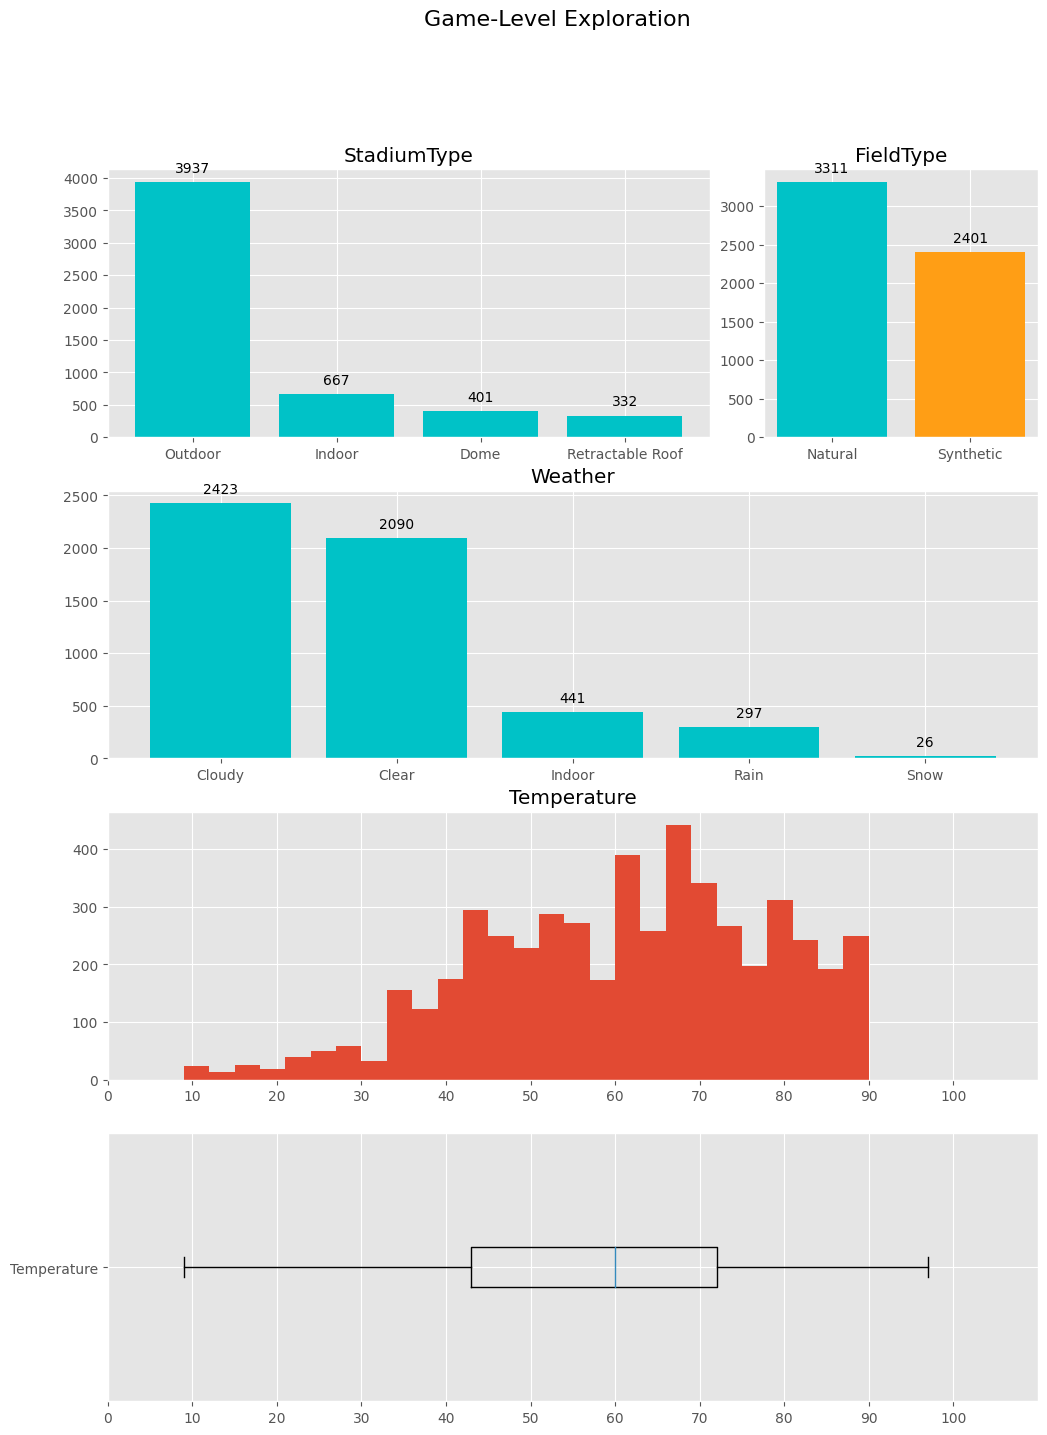

In [ ]:
play_df_cleaned = clean_play_df(play_df)
game_df_cleaned = play_df_cleaned[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])
visualize_game_features(game_df_cleaned, rotation=0, add_labels = True, figsize=(12,16))

The diagrams above show:

* __The majority of the games are played outdoors.__ That's why the weather should be important.
* __Synthetic turf is very common, but there are around 30% more games with natural turf.__
* __The temperature and other weather conditions vary greately__. It will be interesting to look at how the temperature affects the injuries.

`3` Player level exploration:

In [ ]:
player_data_df = play_df_cleaned[['PlayerKey', 'RosterPosition', 'PlayerGamePlay', 'Position', 'PositionGroup']]
#novamente um dataframe sendo instaurado, mas dessa vez par os dados dos jogadores

In [ ]:
def visualize_player_features(player_df, figsize=(25,20), add_labels=False):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=figsize)

    grid = plt.GridSpec(3, 4, hspace=0.2, wspace=0.2)

    plays_ax = fig.add_subplot(grid[0, 0:2])
    max_rolling_plays_ax = fig.add_subplot(grid[1, 0:2])

    rosterposition_ax = fig.add_subplot(grid[0, 2:])
    positiongroup_ax = fig.add_subplot(grid[1, 2:])
    position_ax = fig.add_subplot(grid[2, 0:])

    plays_ax.hist(player_df.groupby(by=['PlayerKey']).count()['RosterPosition'].values, bins=20, color='#00c2c7')
    plays_ax.set_title('Number of plays per player')

    max_rolling_plays_ax.hist(player_df.groupby(by=['PlayerKey']).PlayerGamePlay.max().values, bins=20, color='#00c2c7')
    max_rolling_plays_ax.set_title('Maximum number of rolling plays per player')

    rosterposition_ax.bar(player_df.RosterPosition.value_counts().keys().values, player_df.RosterPosition.value_counts().values)
    rosterposition_ax.set_xticklabels(player_df.RosterPosition.value_counts().keys().values, rotation=20)
    rosterposition_ax.set_title('Roster Position')
    if add_labels:
        add_value_labels(rosterposition_ax, spacing=5)

    position_ax.bar(player_df.Position.value_counts().keys().values, player_df.Position.value_counts().values, color='#ff9e15')
    position_ax.set_title('Position')
    if add_labels:
        add_value_labels(position_ax, spacing=5)

    positiongroup_ax.bar(player_df.PositionGroup.value_counts().keys().values, player_df.PositionGroup.value_counts().values)
    positiongroup_ax.set_title('Position Group')
    if add_labels:
        add_value_labels(positiongroup_ax, spacing=5)

    plt.suptitle('Player-Level Exploration', fontsize=16)
    plt.show()

<ipython-input-9-19e77d578d04>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  rosterposition_ax.set_xticklabels(player_df.RosterPosition.value_counts().keys().values, rotation=20)


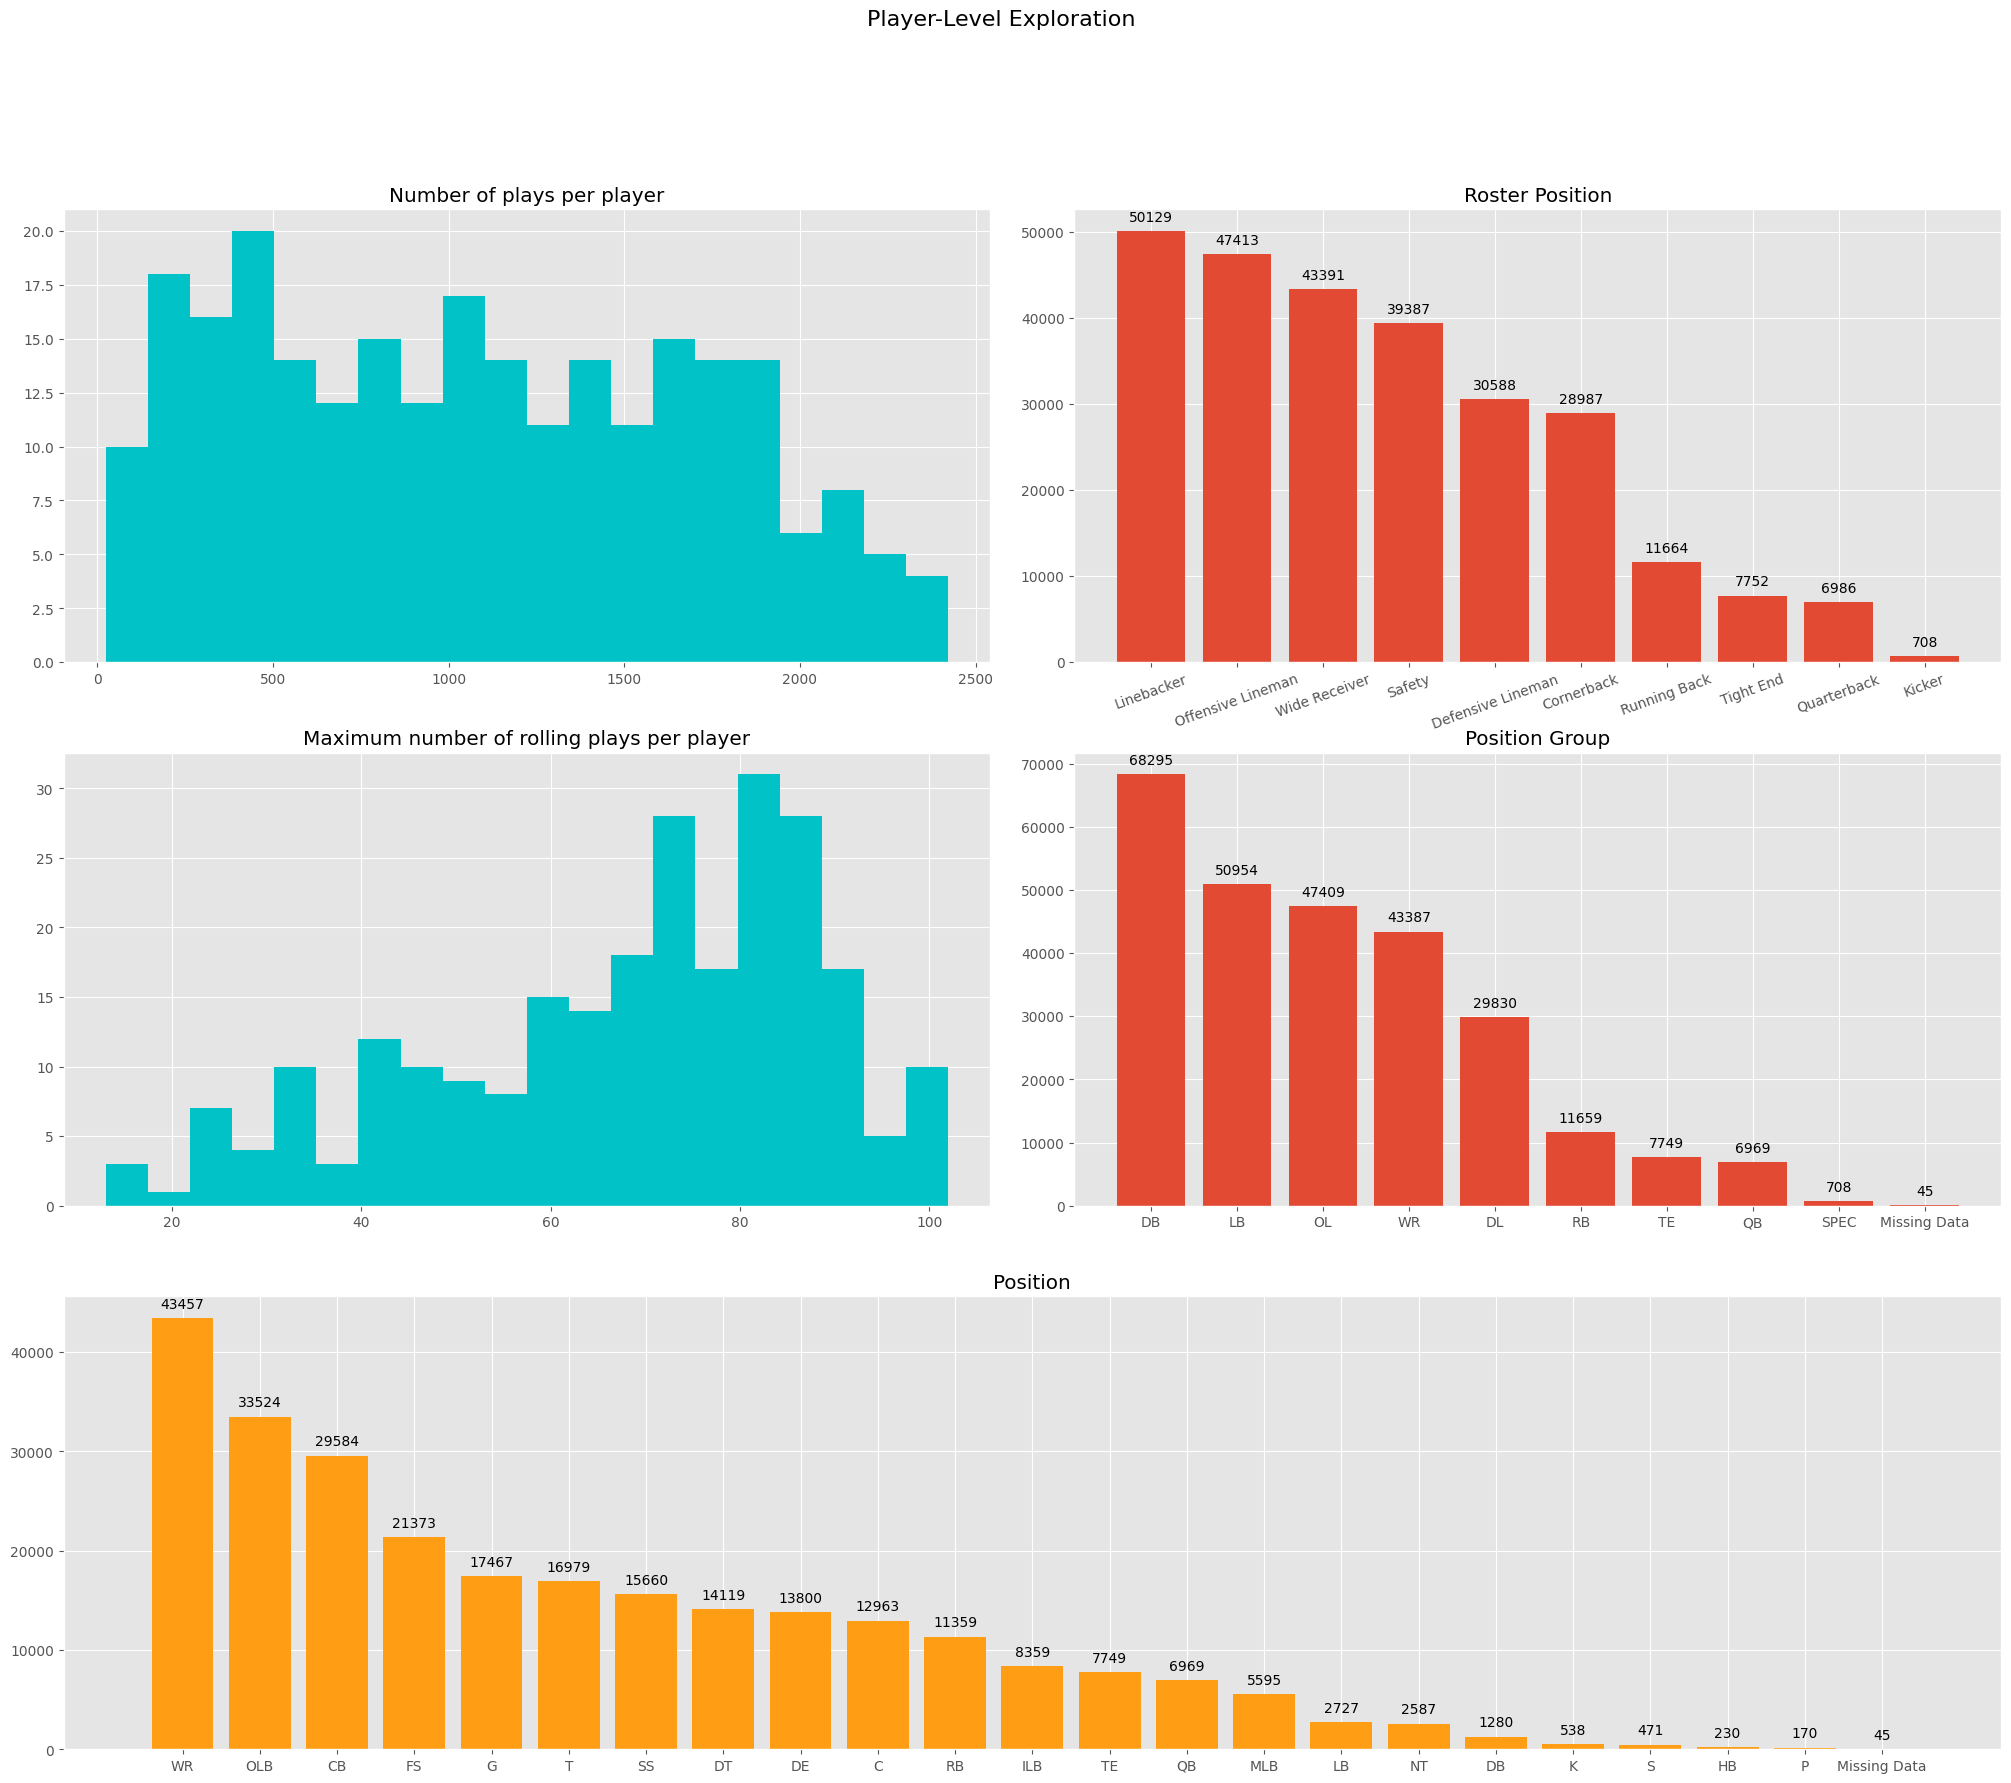

In [ ]:
visualize_player_features(player_data_df, add_labels=True)

The diagrams above show that the circumstances around the players vary greatly: some players do much more games than the others, there is a lot of different playing position. All of these factors can contribute to injuries.

`4` Play-level exploration:

In [ ]:
def visualize_play(play_df_cleaned):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(1,1,figsize=(15,5))

    plt.bar(play_df_cleaned.PlayType.value_counts().keys().values, play_df_cleaned.PlayType.value_counts().values)
    plt.xticks(range(len(play_df_cleaned.PlayType.value_counts().keys().values)), play_df_cleaned.PlayType.value_counts().keys().values, rotation=20)
    add_value_labels(ax, spacing=5)
    plt.title('Play-Level Exploration: PlayType', fontsize=16)

    plt.show()

    #mesma situação dos slides anteriores, dessa vez a plotagem é para os dados de cada jogada

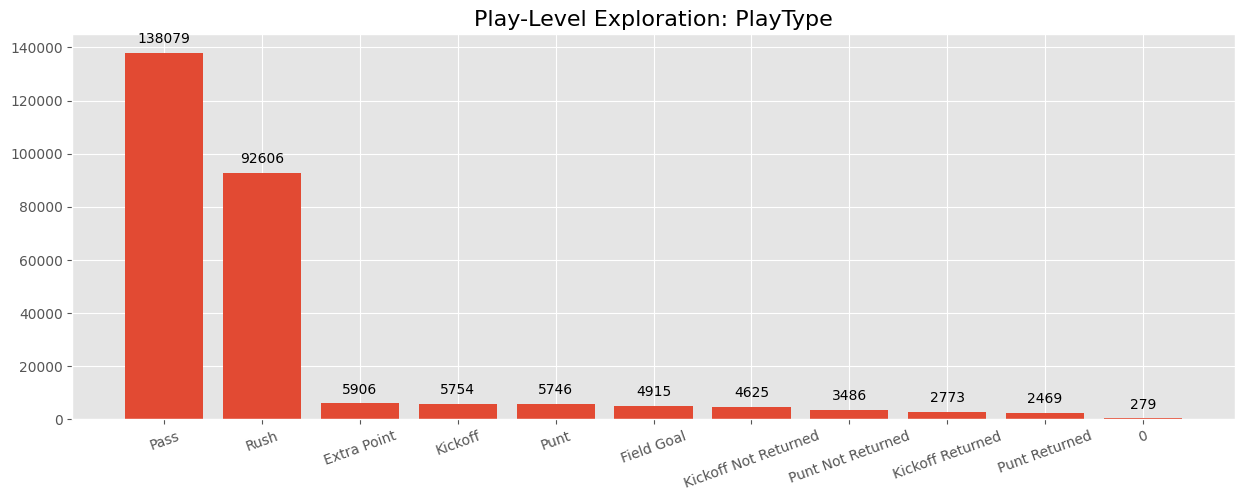

In [ ]:
visualize_play(play_df_cleaned)

To my mind, it will be exciting to see how play types affect the injury. I guess that some play types can cause much more dangerous situations than others!

### Player Dataset Visualization and Exploration

`1` Visualize players positions and paths:

To my mind, this is the most exciting part: we can take actual data and track the player's position!

Let's start with visualizing just one line of the dataset:

In [ ]:
def get_position(player_df, playkey, time):
    '''
    Helper function to get the player position at a certain time
    '''
    row = player_df[(player_df['PlayKey']==playkey) & (player_df['time']==time)]
    event = row['event'].values[0]
    x = row['x'].values[0]
    y = row['y'].values[0]
    direction = row['dir'].values[0]
    distance = row['dis'].values[0]
    orientation = row['o'].values[0]
    speed = row['s'].values[0]

    return event, x, y, direction, distance, orientation, speed

def visualize_player_position(player_df, playkey, time, figsize=(24,10)):
    '''
    Helper function to visualize a single player position.
    '''

    event, x, y, direction, distance, orientation, speed = get_position(player_df, playkey, time)

    background = Image.open('../input/nfl-utils/nfl_coordinates.png')
    background = background.resize((1200,533))
    background = background.transpose(PIL.Image.FLIP_TOP_BOTTOM)

    # show background
    fig = plt.figure(figsize=figsize)
    plt.imshow(np.array(background).transpose(0,1,2), origin='lower')

    # show orientation
    dx = 5
    dy = dx*np.tan(np.radians(90 + orientation))
    plt.arrow(x*10,y*10,dx,dy, color = '#767676', width=5)
    plt.plot(x*10,y*10,color = '#767676', label='orientation')

    # show speed
    dx = speed*20
    dy = dx*np.tan(np.radians(90 + direction))
    plt.arrow(x*10,y*10,dx,dy, color = '#004c97', width=5)
    plt.plot(x*10,y*10, color = '#004c97', label='speed')

    # show current player position
    plt.scatter(x*10,y*10,s=200,color='#e01e5a',marker='x')
    plt.annotate('({x:.1f},{y:.1f})'.format(x=x,y=y), (x*10, y*10), xytext=(x*10,y*10-30), color='#e01e5a')

    plt.xticks(range(0,1200,100), range(0,120,10))
    plt.yticks(range(0,533,100), range(0,53,10))

    plt.title('{play}:{time} {event}'.format(play=playkey, time=time, event = event))

    plt.legend()
    plt.show()

We can also plot the entire path of the player during the play and see how he moved:

In [ ]:
def visualize_player_track(player_df, playkey, figsize=(24,10), max_positions = 5):
    '''
    Helper function to visualize the whole path of the player
    '''
    # get timestamps per player
    timestamps = player_df[player_df['PlayKey'] == playkey].time.unique()

    background = Image.open('../input/nfl-utils/nfl_coordinates.png')
    background = background.resize((1200,533))
    background = background.transpose(PIL.Image.FLIP_TOP_BOTTOM)

    # show background
    fig = plt.figure(figsize=figsize)
    plt.imshow(np.array(background).transpose(0,1,2), origin='lower')

    # iterate through timestamps
    positions_x, positions_y = [], []
    for i in range(0, len(timestamps), len(timestamps) // max_positions):
        time = timestamps[i]
        # get position and orientation
        event, x, y, direction, distance, orientation, speed = get_position(player_df, playkey, time)
        positions_x.append(x*10)
        positions_y.append(y*10)

        # plot orientation and speed for the lasi point
        if (len(timestamps) - i < len(timestamps) // max_positions):
            # show orientation
            dx = 5
            dy = dx*np.tan(np.radians(90 + orientation))
            plt.arrow(x*10,y*10,dx,dy, color = '#767676', width=5)
            plt.plot(x*10,y*10,color = '#767676', label='orientation')

            # show speed
            dx = speed*20
            dy = dx*np.tan(np.radians(90 + direction))
            plt.arrow(x*10,y*10,dx,dy, color = '#004c97', width=5)
            plt.plot(x*10,y*10, color = '#004c97', label='speed')

            # add x-marker and annotation only for the last position
            plt.scatter(x*10,y*10,s=200,color='#e01e5a',marker='x')
            plt.annotate('({x:.1f},{y:.1f})'.format(x=x,y=y), (x*10, y*10), xytext=(x*10,y*10-30), color='#e01e5a')

    # show player's path
    plt.scatter(positions_x,positions_y,s=50,color='#e01e5a',marker='o')
    plt.plot(positions_x,positions_y,color='#e01e5a', label='player path', linestyle='--')

    # creat custom tick labels
    plt.xticks(range(0,1200,100), range(0,120,10))
    plt.yticks(range(0,533,100), range(0,53,10))

    # add title
    plt.title('{play}'.format(play=playkey))

    plt.legend()
    plt.show()

`2` Create a heatmap of the field

Let's look at the heatmap of the field:

In [ ]:
def visualize_field_heatmap(player_df, xbins=13, ybins=6, annotate = False):
    # create a grid
    x = np.linspace(0, 120, xbins)
    y = np.linspace(0, 53, ybins)

    # initialize heatmap
    hmap = np.zeros((xbins,ybins))

    for i in range(xbins-1):
        for j in range(ybins-1):
            hmap[i,j] = len(player_df[(player_df.x >= x[i]) & (player_df.x <= x[i+1]) & (player_df.y >= y[j]) & (player_df.y <= y[j+1])])

    fig = plt.figure(figsize=(10,5))
    ax = sns.heatmap(np.transpose(hmap), annot=annotate, fmt = '.0f')
    plt.title('Field Heatmap \n the most visited areas of the field are highlighted')
    plt.show()

We can see that some areas of the field are more 'busy' than the others.

### Injuries Dataset EDA

Let's look quickly at the injuries:

In [ ]:
#análise rápida para observação de alguns dados específicos do dataset de lesões

In [ ]:
print('There are {} injury records in total.'.format(len(injury_df)))

There are 105 injury records in total.


In [ ]:
print('{} unique players injured'.format(len(injury_df.PlayerKey.unique())))

100 unique players injured


This means that there are players injured twice!

In [ ]:
print('There are {} PlayKey values missing.'.format(len(injury_df) - injury_df.PlayKey.count()))

There are 28 PlayKey values missing.


For around 30% of the injuries, we don't know the play, when the injury took place. It is quite a significant number.

In [ ]:
def visualize_injury(injury_df):
    injury_df_cleaned = injury_df.copy()
    injury_df_cleaned.DM_M1 = injury_df_cleaned.DM_M1 - injury_df_cleaned.DM_M7
    injury_df_cleaned.DM_M7 = injury_df_cleaned.DM_M7 - injury_df_cleaned.DM_M28
    injury_df_cleaned.DM_M28 = injury_df_cleaned.DM_M28 - injury_df_cleaned.DM_M42

    fig, axs = plt.subplots(1,3, figsize=(15,5))

    axs[0].bar(injury_df_cleaned.BodyPart.value_counts().keys().values, injury_df_cleaned.BodyPart.value_counts().values, color='#00c2c7')
    axs[0].set_title('Body Part')
    add_value_labels(axs[0], spacing=5)

    axs[1].bar(injury_df_cleaned.Surface.value_counts().keys().values, injury_df_cleaned.Surface.value_counts().values, color='#ff9e15')
    axs[1].set_title('Surface')
    add_value_labels(axs[1], spacing=5)

    M1 = injury_df_cleaned.DM_M1.sum()
    M7 = injury_df_cleaned.DM_M7.sum()
    M28 = injury_df_cleaned.DM_M28.sum()
    M42 = injury_df_cleaned.DM_M42.sum()

    axs[2].bar(['1-7', '7-28', '28-42', '>=42'], [M1, M7, M28, M42])
    axs[2].set_title('Missed Days')
    add_value_labels(axs[2], spacing=5)

    plt.suptitle('Injury', fontsize=16)
    plt.show()
    #mesmo processo dos datasets anteriores, agora para fazer a plotagem das lesões e suas ocorrências

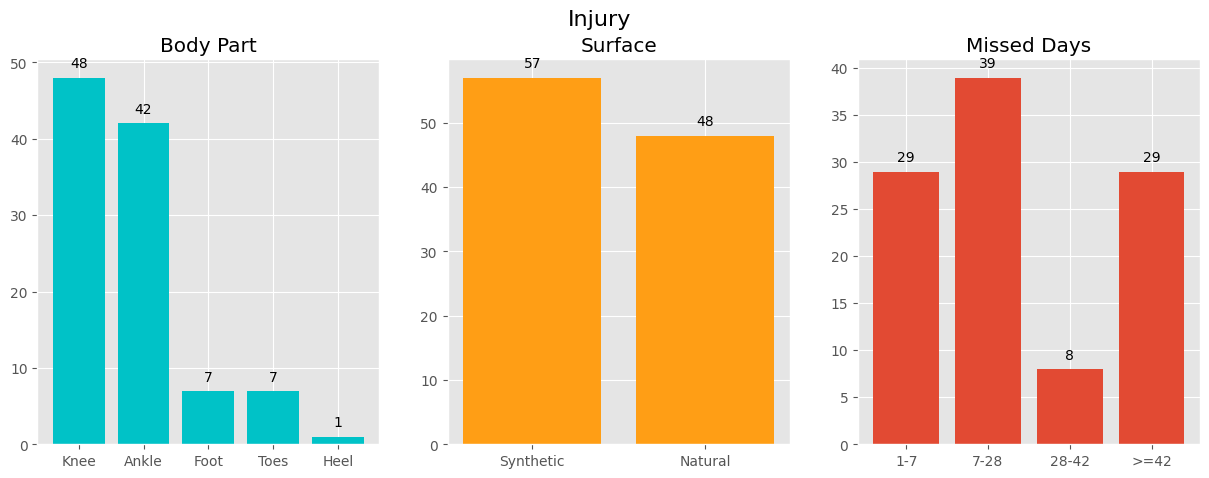

In [ ]:
visualize_injury(injury_df)

All in all, we have just **105** injury records! So few!

* We can see that the __knees and ankles are the most frequently injured body parts.__
* We have almost __equal number of observations for synthetic and natural surface.__

## Injury Analysis

`1` Merge injury data with game data (drop the play-level information), so we can explore the dependencies between the injuries and game-level factors.

In [ ]:
# Juntou o conjunto de dados de jogos limpo com o conjunto de dados de lesões.
game_injury_df = injury_df.set_index('GameID').join(game_df_cleaned.set_index('GameID'), how = 'outer')

# Preenche os valores nulos nas colunas de lesões com zeros.
game_injury_df['DM_M1'] = game_injury_df['DM_M1'].fillna(0).astype(int)
game_injury_df['DM_M7'] = game_injury_df['DM_M7'].fillna(0).astype(int)
game_injury_df['DM_M28'] = game_injury_df['DM_M28'].fillna(0).astype(int)
game_injury_df['DM_M42'] = game_injury_df['DM_M42'].fillna(0).astype(int)

game_injury_df.DM_M1 = game_injury_df.DM_M1 - game_injury_df.DM_M7
game_injury_df.DM_M7 = game_injury_df.DM_M7 - game_injury_df.DM_M28
game_injury_df.DM_M28 = game_injury_df.DM_M28 - game_injury_df.DM_M42

# Introduz uma coluna com uma flag indicando uma lesão.
game_injury_df['Injury'] = game_injury_df['DM_M1'] + game_injury_df['DM_M7'] + game_injury_df['DM_M28'] + game_injury_df['DM_M42']

# Remove a coluna de superfície duplicada.
game_injury_df = game_injury_df.drop(columns=['Surface'])

# Remove as características do nível de jogada por enquanto.
game_injury_df = game_injury_df.drop(columns=['PlayerKey', 'PlayKey'])

# Cria variáveis dummy
game_injury_df_dummies = pd.get_dummies(game_injury_df, dummy_na = True, drop_first = True).drop(columns=['FieldType_nan'])

`2` Now let's visualize the correlations:

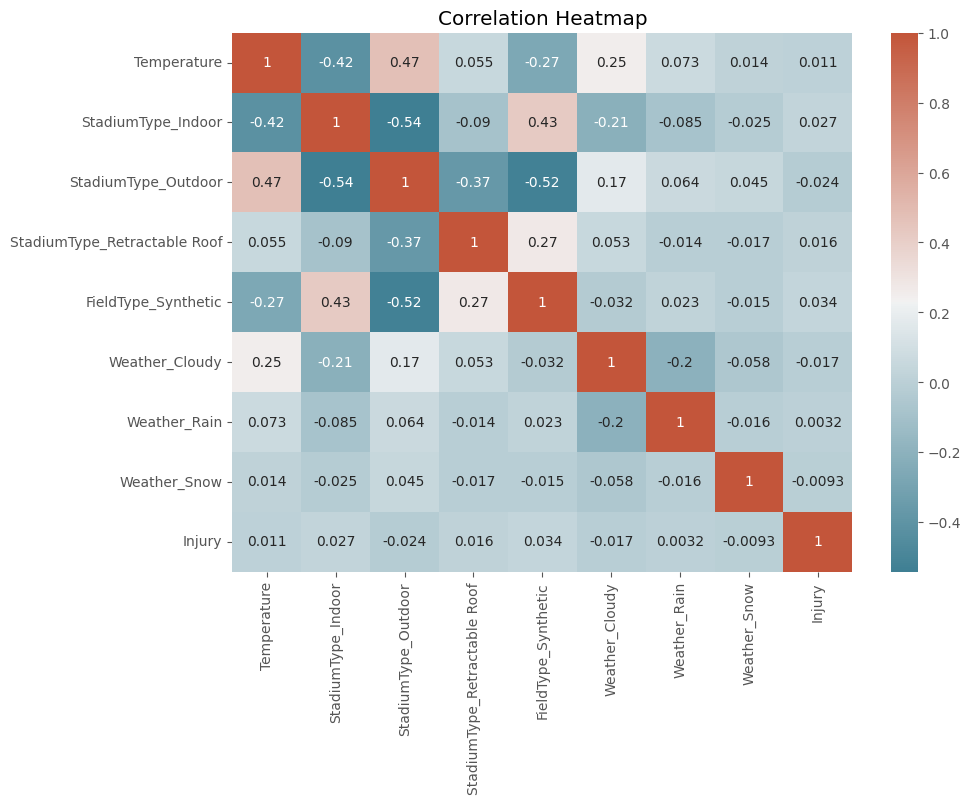

In [ ]:
corr_df = game_injury_df_dummies[['Temperature', 'StadiumType_Indoor', 'StadiumType_Outdoor', 'StadiumType_Retractable Roof',
                                 'FieldType_Synthetic', 'Weather_Cloudy', 'Weather_Rain', 'Weather_Snow', 'Injury']].corr()

fig = plt.figure(figsize=(10,7))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

Unfortunately, there is __no correlation between our features and the injury.__

Let's look at [Cramer's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V):

In [ ]:
# Source:
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [ ]:
# Source:
# https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features
def plot_cramers_v_heatmap(df, cols):
    corrM = np.zeros((len(cols),len(cols)))

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_v(pd.crosstab(df[col1], df[col2]).as_matrix())
        corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    fig, ax = plt.subplots(figsize=(7, 6))
    ax = sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax); ax.set_title("Cramer V Correlation between Variables");

This table looks way more exciting!
* We can see that there are correlations between Weather and Temperature (obviously, snow and rain means lower temperature than sunny weather).
* There is also some correlation between Stadium Type and Temperature.

But unfortunately, still no correlation with the injury.

Let's try [Theil’s U](https://docs.oracle.com/cd/E40248_01/epm.1112/cb_statistical/frameset.htm?ch07s02s03s04.html) to find some insights:

In [ ]:
# Source:
# https://github.com/shakedzy/dython/blob/master/dython/nominal.py

from collections import Counter
import math

def conditional_entropy(x, y, nan_strategy='replace', nan_replace_value=0):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    **Returns:** float
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples with missing values, or 'replace'
        to replace all missing values with the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when nan_strategy is set to 'replace'.
    """
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [ ]:
def plot_theils_u_heatmap(df, cols):
    corrM = np.zeros((len(cols),len(cols)))

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = theils_u(df[col1].values, df[col2].values)
        corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    fig, ax = plt.subplots(figsize=(7, 6))
    ax = sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax); ax.set_title("Theil's U Correlation between Variables");

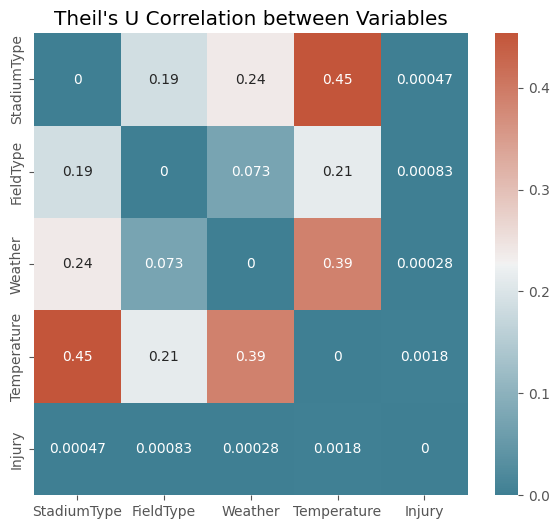

In [ ]:
cols = ["StadiumType", "FieldType", "Weather", "Temperature", "Injury"]
plot_theils_u_heatmap(game_injury_df, cols)

Again, no insights on  the injury.

`3` Explore the game features with respect to the injury:

Temperature:

In [ ]:
# get the temperature values for games
# be sure to only take the values where the game was played outdoors
non_injury_temp = game_injury_df[(game_injury_df.StadiumType == 'Outdoor') & (game_injury_df.Temperature >= 0) & (game_injury_df.Injury == 0)].Temperature.values
injury_temp = game_injury_df[(game_injury_df.StadiumType == 'Outdoor') & (game_injury_df.Temperature >= 0) & (game_injury_df.Injury == 1)].Temperature.values

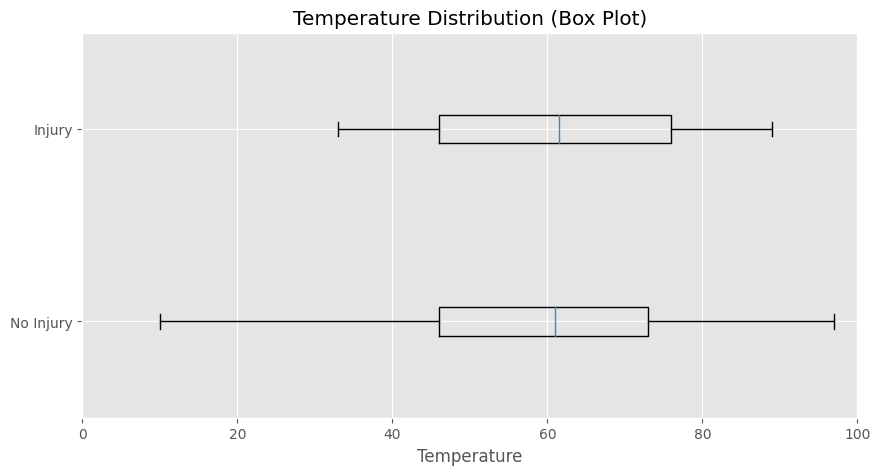

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.boxplot([non_injury_temp, injury_temp], vert = False)
plt.title('Temperature Distribution (Box Plot)')
plt.yticks([1,2], ['No Injury', 'Injury'])
plt.xlim(0,100)
plt.xlabel('Temperature')
plt.show()

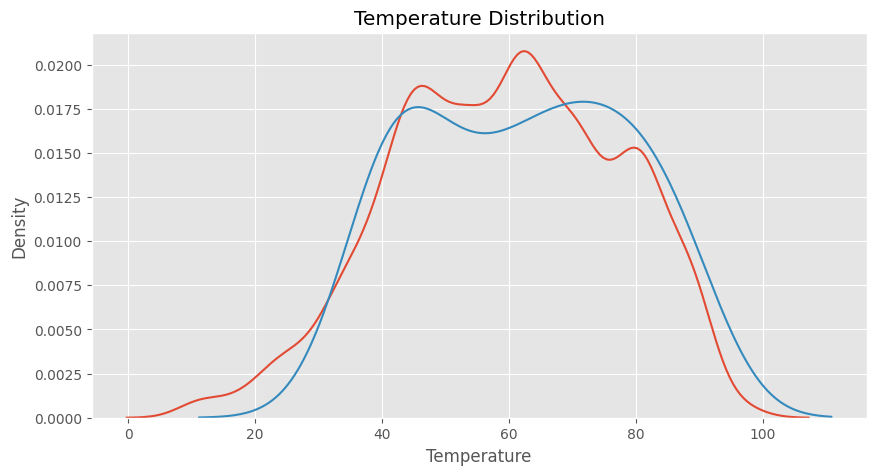

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(10,5))
sns.kdeplot(non_injury_temp, label = 'No Injury')
sns.kdeplot(injury_temp, label = 'Injury')
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.show()

Check the Kolmogorov-Smirnov test to check if the temperature samples come from one distribution:

In [ ]:
# compare maximum play speed samples
D, pvalue = ss.ks_2samp(non_injury_temp, injury_temp)
D, pvalue

(0.09720742964110508, 0.5577315244251334)

The p-value is high. We can't say that temperature values come from different distributions.

`4` Hypothesis testing

Let's try a simple hypothesis test to check if the number of injuries on synthetic turf is significantly higher. We see that basically, the probability of injury is higher when playing on synthetic turf. But is this statistically significant?

In [ ]:
#O processo abaixo vai ser para testar a hipótese da lesão e avaliar os resultados
#Computa a probabilidade de lesão para grama sintética e natural.
p_injury = game_injury_df[['FieldType', 'Injury']].groupby('FieldType').mean()['Injury']
p_injury

FieldType
Natural      0.014497
Synthetic    0.023730
Name: Injury, dtype: float64

The null hypothesis is that the probability of the injury on natural turf is less or equal to the probability of the injury on synthetic turf.

In [ ]:
# get number of trials and overall injury rate under null
n_natural = game_injury_df[['FieldType', 'Injury']].groupby('FieldType').size()[0]
n_synthetic = game_injury_df[['FieldType', 'Injury']].groupby('FieldType').size()[1]

p_null = game_injury_df[['FieldType', 'Injury']][game_injury_df.FieldType == 'Natural'].mean()[0]

<ipython-input-34-895f8ce49b26>:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  p_null = game_injury_df[['FieldType', 'Injury']][game_injury_df.FieldType == 'Natural'].mean()[0]


In [ ]:
# computa o erro padrão
se_p = np.sqrt(p_null * (1-p_null) * (1/n_natural + 1/n_synthetic))

#  computa o z-score e o p-valor
z = (p_injury[1] - p_injury[0]) / se_p

print('The z-score is: {}'.format(z))
print('The p-value is: {}'.format(1-ss.norm.cdf(z)))

#com um p-valor menor que 0.05, pode se concluir com mais de 99% de confiança que a probabilidade de lesão no sintético é maior que na natural

The z-score is: 2.882114721816435
The p-value is: 0.001975079424302306


Under 95% confidence, we reject the null hypothesis if the p-value is less than 0.05. Our computed p-value is approximately 0.002, so we can reject the null hypothesis that the probability of injury on natural turf is less or equal than the injury probability on the synthetic turf. We can conclude that the probability of the injury on synthetic turf is higher than the probability of the injury on natural turf (with 99% confidence).

`5` Play-level features:

In [ ]:
# joined cleaned games dataset and injury dataset
play_injury_df = injury_df.dropna(subset=['PlayKey']).set_index('PlayKey').join(play_df_cleaned.set_index('PlayKey'), how = 'outer', lsuffix='_left', rsuffix='_right')

# fill null values for the injury columns with zeros
play_injury_df['DM_M1'] = play_injury_df['DM_M1'].fillna(0).astype(int)
play_injury_df['DM_M7'] = play_injury_df['DM_M7'].fillna(0).astype(int)
play_injury_df['DM_M28'] = play_injury_df['DM_M28'].fillna(0).astype(int)
play_injury_df['DM_M42'] = play_injury_df['DM_M42'].fillna(0).astype(int)

# introduce a column with a flag indicating an injury
play_injury_df.DM_M1 = play_injury_df.DM_M1 - play_injury_df.DM_M7
play_injury_df.DM_M7 = play_injury_df.DM_M7 - play_injury_df.DM_M28
play_injury_df.DM_M28 = play_injury_df.DM_M28 - play_injury_df.DM_M42

play_injury_df['Injury'] = play_injury_df['DM_M1'] + play_injury_df['DM_M7'] + play_injury_df['DM_M28']+ play_injury_df['DM_M42']

# drop duplicated surface column
play_injury_df = play_injury_df.drop(columns=['Surface'])

# create dummy variables
play_injury_df_dummies = pd.get_dummies(play_injury_df, columns = ['PlayType', 'PositionGroup'], dummy_na = True, drop_first = True)

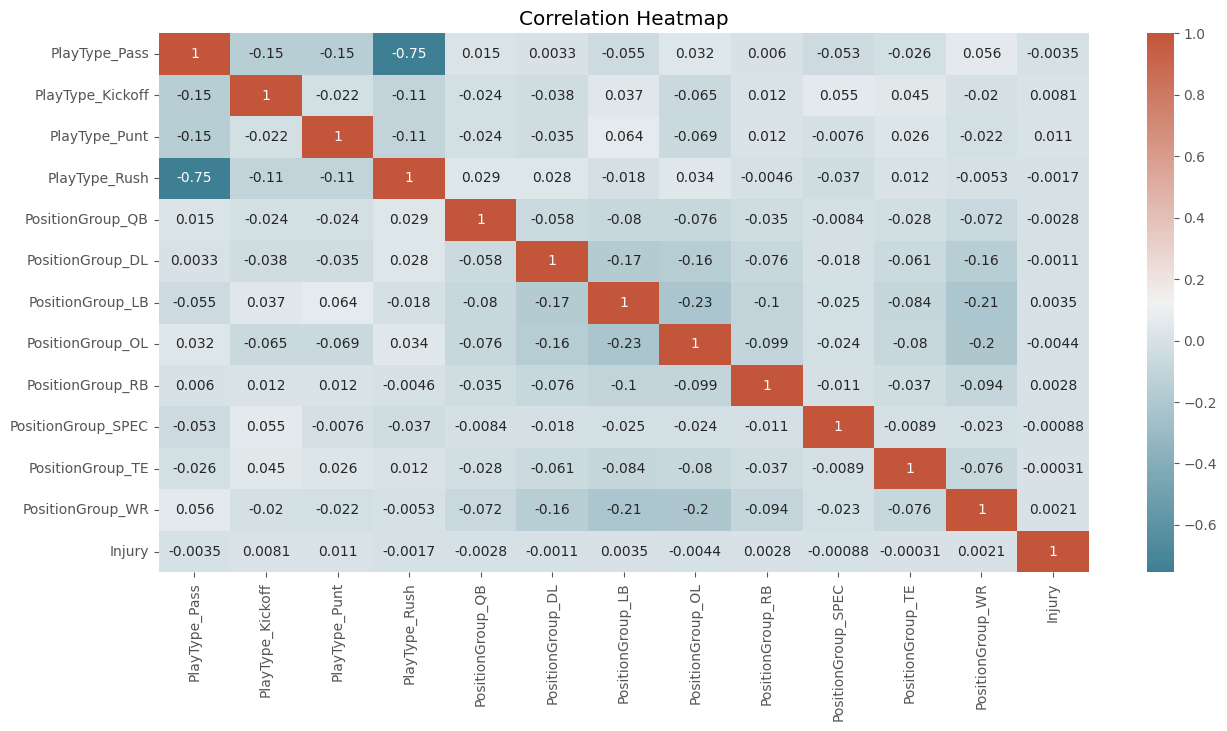

In [ ]:
corr_df = play_injury_df_dummies[['PlayType_Pass', 'PlayType_Kickoff', 'PlayType_Punt', 'PlayType_Rush',
                                  'PositionGroup_QB', 'PositionGroup_DL', 'PositionGroup_LB', 'PositionGroup_OL',
                                  'PositionGroup_RB', 'PositionGroup_SPEC', 'PositionGroup_TE', 'PositionGroup_WR',
                                  'Injury']].corr()

fig = plt.figure(figsize=(15,7))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

Cramer's V:

Again, this chart shows us some obvious correlations, but still, nothing is correlated with the injury.

Let's tru Theil's U:

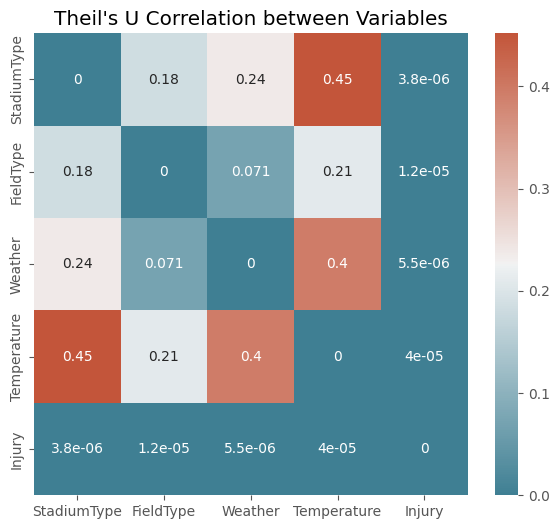

In [ ]:
plot_theils_u_heatmap(play_injury_df, cols)

Unfortunately, there are no insights on injury.

Visualize the heatmap of the field with the plays with the injury:

It looks like the heatmap of injuries is somewhat different from the general heatmap of the field! Probably, there are more dangerous areas on the field, where players are more likely to get injured!

We can use this insight for the feature engineering for the injury prediction model!

In [ ]:
def visualize_field_kde(player_df):
    # plot kde
    fig = plt.figure(figsize=(10,5))
    ax = sns.jointplot(x="x", y="y", data=player_df, kind="kde")
    plt.show()

This is the KDE plot for the injury play locations on the field:

## Game Timeline and Injury Analysis

Let's plot a timeline of player's games and highlight the days with injuries:

In [ ]:
def player_games_timeline(player_key, play_df, injury_df):
    '''
    Function to plot the player's timeline
    '''
    player_games = play_df[play_df.PlayerKey == player_key][['GameID', 'PlayKey', 'PlayerDay', 'PlayerGame']]

    # plot timeline for the player
    plt.figure(figsize=(20,5))
    plt.title('Player Games Timeline \n PlayerKey: ' + str(player_key))
    plt.plot(player_games.PlayerDay.unique(), np.zeros(len(player_games.PlayerDay.unique())), color='#00c2c7')
    plt.scatter(player_games.PlayerDay.unique(), np.zeros(len(player_games.PlayerDay.unique())), s=100, color='#00c2c7', label='games')

    # add games with injury
    injured_players = injury_df.PlayerKey.unique()
    if player_key in injured_players:
        injury_games = injury_df[injury_df.PlayerKey == player_key].GameID.values
        injury_days = player_games[player_games.GameID.isin(injury_games)].PlayerDay.unique()

        plt.scatter(injury_days, np.zeros(len(injury_days)), s=100, color='#e01e5a', label='injury')

    plt.legend()
    plt.xlabel('days')
    plt.yticks([])
    plt.show()

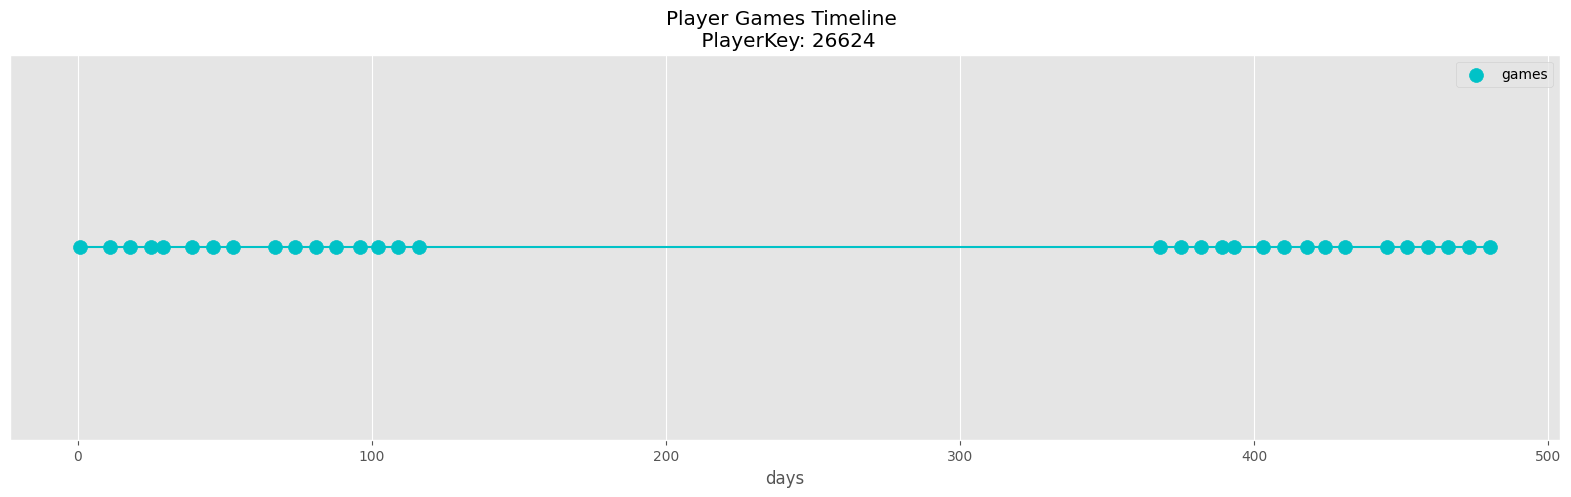

In [ ]:
player_games_timeline(26624, play_df, injury_df)

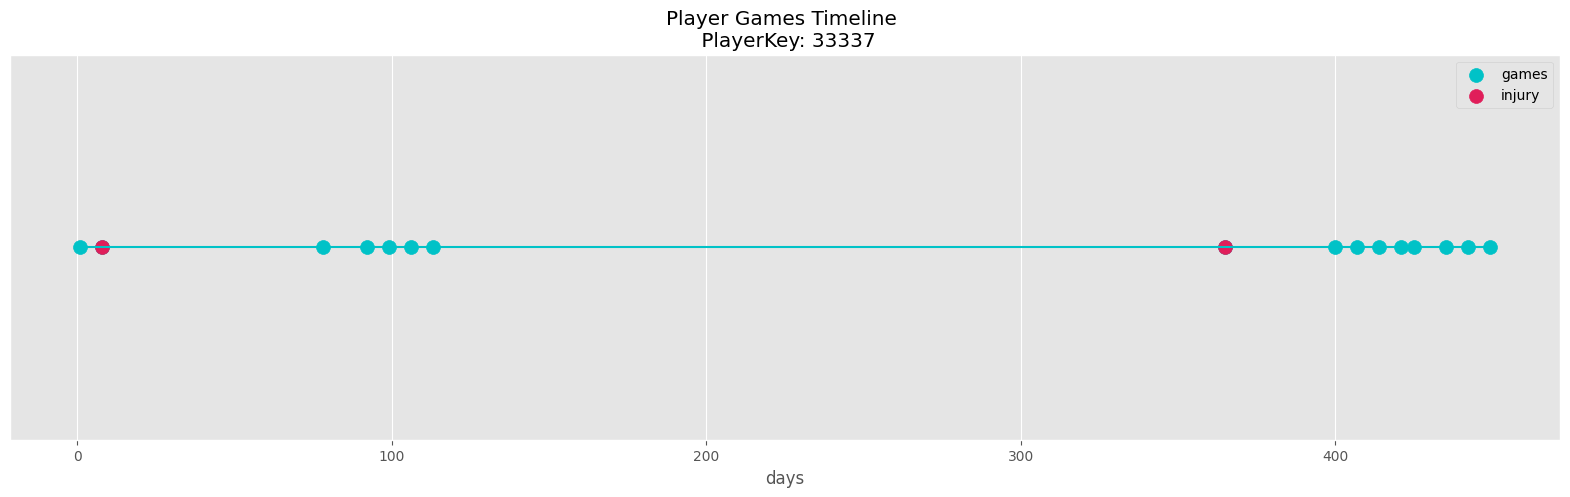

In [ ]:
player_games_timeline(33337, play_df, injury_df)

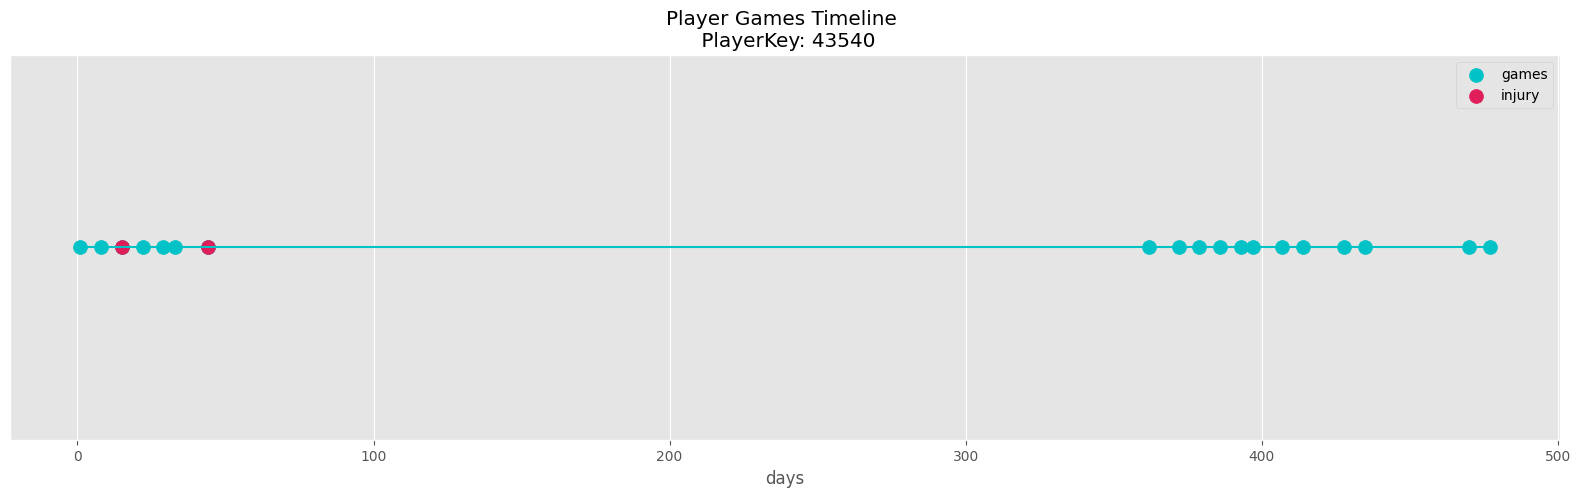

In [ ]:
player_games_timeline(43540, play_df, injury_df)

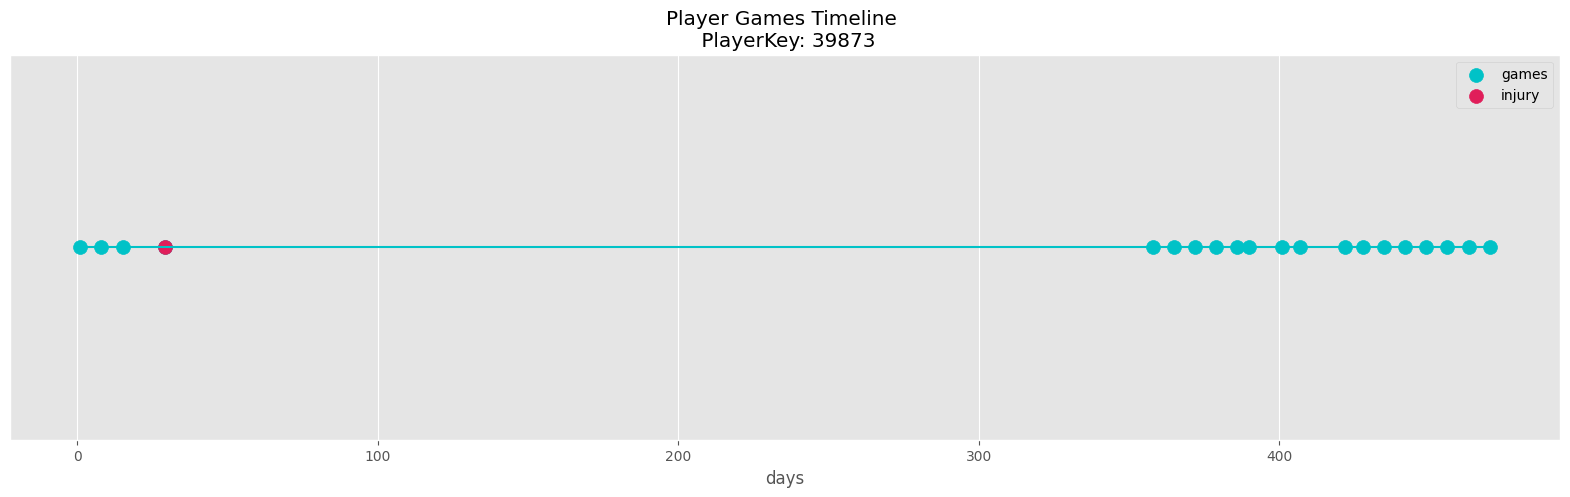

In [ ]:
player_games_timeline(39873, play_df, injury_df)

I picked some random injured players from the dataset. It seems that injuries happen at the beginning of the season (for each player).

So is the speed of the player, his position on the field and the number of the game (`PlayerGame`) correlated with the injury?

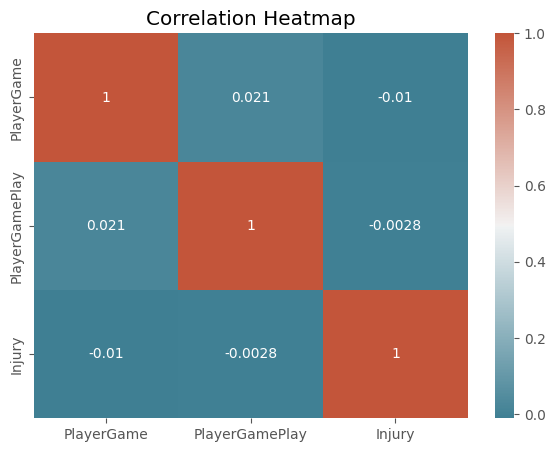

In [ ]:
play_injury = play_injury_df[['PlayerGame', 'PlayerGamePlay', 'Injury']]
corrs = play_injury.corr()

fig = plt.figure(figsize=(7,5))
sns.heatmap(corrs, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

The diagram above shows that there is no correlation between the injury and the number of games/plays per game played.

## Data Engineering

O próximo passo é tentar extrair características e construir um modelo para prever a lesão. A expectativa é que consiga obter a importância das características deste modelo e descobrir os fatores que contribuem para a lesão.

In [ ]:
# reinicia o índice
features_df = play_injury_df.copy().reset_index()
# descarta as colunas irrelevantes
features_df = features_df.drop(columns=['PlayerKey_left','GameID_left','BodyPart', 'PlayKey', 'PlayerKey_right', 'GameID_right', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'])
# as transforma em váriáveis dummy
features_df = pd.get_dummies(features_df, dummy_na = False, drop_first = True)

## Machine Learning

Com os dados preparaos e processados, podemos começar com a parte do Machine Learning

`1` Split into features and targets:

In [ ]:
# separa em features e targets
y = features_df['Injury']
X = features_df.drop(columns=['Injury'])

import numpy as np
from sklearn.datasets import load_iris
import pandas as pd

# Loading irirs dataset
df = pd.DataFrame(X)
display(df)



,PlayerDay,PlayerGame,Temperature,PlayerGamePlay,RosterPosition_Defensive Lineman,RosterPosition_Kicker,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,RosterPosition_Quarterback,RosterPosition_Running Back,...,Position_WR,PositionGroup_DL,PositionGroup_LB,PositionGroup_Missing Data,PositionGroup_OL,PositionGroup_QB,PositionGroup_RB,PositionGroup_SPEC,PositionGroup_TE,PositionGroup_WR
0,1,1,63,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,1,1,63,10,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,1,1,63,11,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,1,1,63,12,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,1,1,63,13,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267001,71,9,53,54,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
267002,71,9,53,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
267003,71,9,53,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
267004,71,9,53,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2` Use stratified split to split into train and test set so that class labels will be evenly distributed among the train and the test set:

In [ ]:
skf = StratifiedKFold(n_splits=2)
#usa separação estratificada para treinar o conjunto de treino para distribuir igualmente os rótulos em todas as classes
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.values[train_index, :], X.values[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

`3` Resampling the dataset:

The number of plays with injury is so tiny that we can't just use the data as-is. Our model will only always predict no injury. That is why we need to resample our dataset. Resampling will help us to generate more examples of cases from the rare class (the injury), so we can train our model! I will use [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/index.html) library.

In [ ]:
res = RandomOverSampler(random_state=0)
X_resampled, y_resampled = res.fit_resample(X_train, y_train)
#com um número ínfimo de lesões, é preciso rearranjar o dataset para a predição não resultar sempre em não lesão

`4` Training the model:

In [ ]:
model = xgb.XGBClassifier(max_depth=3,
                      learning_rate=0.1,
                      n_estimators=100,
                      objective='binary:logistic',
                      booster='gbtree',
                      tree_method='auto',
                      n_jobs=50,
                      gamma=0,
                      min_child_weight=1,
                      max_delta_step=0,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      colsample_bynode=1,
                      reg_alpha=0,
                      reg_lambda=1,
                      scale_pos_weight=1,
                      base_score=0.5,
                      random_state=42)
model.fit(X_resampled, y_resampled)
#o modelo xgboost sendo treinado

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=50, num_parallel_tree=None, random_state=42, ...)

`5` Evaluate the model:

In [ ]:
y_pred = model.predict(X_test)
#atribuindo a predição dos modelos com o resultado dos conjuntos de teste
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
cohen_kappa = cohen_kappa_score(y_test, y_pred)
#acima aferindo cada um dos scores em relação a predição
print('Accuracy: {}'.format(accuracy))
print('Cohen kappa: {}'.format(cohen_kappa))
print('Confusion Matrix: \n {}'.format(conf_matrix))

Accuracy: 0.8972008119667723
Cohen kappa: 0.00014560738567293008
Confusion Matrix: 
 [[119774  13690]
 [    34      5]]


The model's performance is quite poor, but we can still look at the feature importances:

In [ ]:
# extrai a importância das features do modelo XGBoost
feature_importances = model.feature_importances_
feature_importances = pd.DataFrame(feature_importances, index = X.columns).reset_index().rename(columns={'index':'feature', 0:'importance'}).sort_values(by=['importance'], ascending=False)

#print(feature_importances)

import numpy as np
from sklearn.datasets import load_iris
import pandas as pd

# Loading irirs dataset
#df = pd.DataFrame(feature_importances)
#display(df)

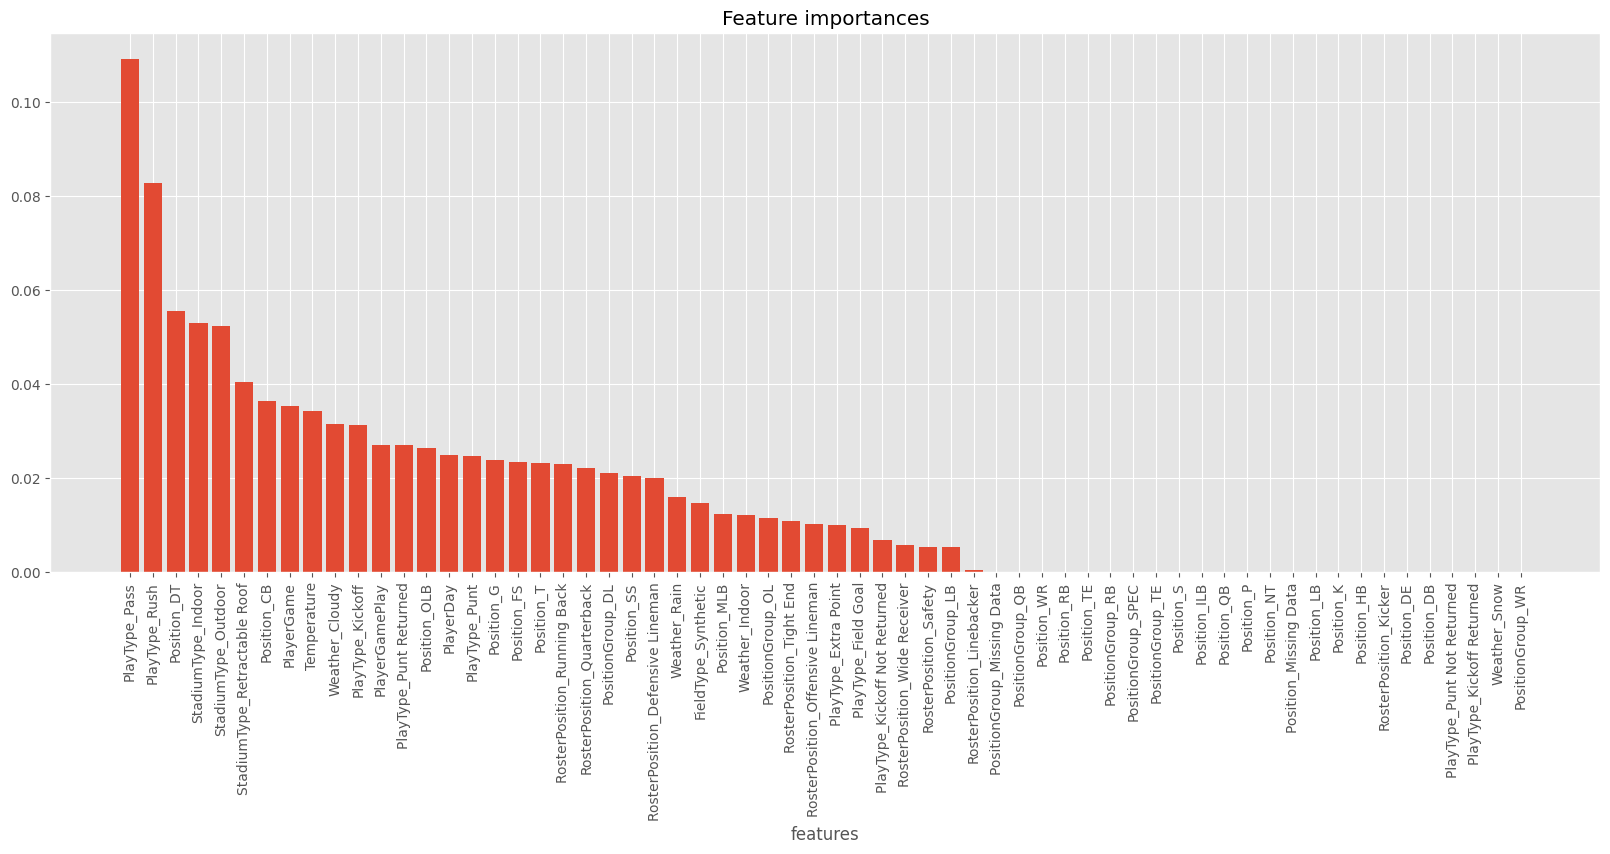

In [ ]:
# plotando como gráfica de barras
plt.figure(figsize=(20,7))
plt.bar(range(len(feature_importances)), feature_importances.importance.values)
plt.xticks(range(len(feature_importances)), feature_importances.feature.values, rotation=90)

plt.title('Feature importances')
plt.xlabel('features')
plt.show()

Looking at the chart above, we can say:
* Play type is among features impacting injury;
* Field type feature is also among the important features in our injury predicting model;
* Player game and plyer day are also among the important features impacting the injury.

## Conclusions:
* There is a higher risk of injury when playing on the synthetic turf
* Under severe weather conditions (rain or snow) players on the synthetic turf tend to have a lower speed than the players on natural turf
* Probably, the synthetic turf can't sustain the high speed. It makes the players slow down when the weather is bad. Probably, moving too fast on synthetic turf could even raise the risk of injury when playing in a certain position

## References and Credits
1. [Great Medium article](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9) on correlation for categorical variables. I highly encourage to read it!
2. [dython library](https://github.com/shakedzy/dython/blob/master/dython/nominal.py): The implementation of Theil's U

__I will further update this notebook, so, please, feel free to ask questions and add comments!__